In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
from scipy.integrate import solve_ivp
import  model_utils as mu
from scipy.optimize import curve_fit
import cma
import params
from tqdm import tqdm

C:\Users\Sofia\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Sofia\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
def runModel1(t, init_values, ka, kc, kd):
        """
        Function to run model in ODE solver
        
        Function to generate string of functions for passing to ODE solver
    
        init_values:    List of initial concentration of free pre-miRNA concentration for
                        each pre-mirna, pre-mirna x dicer concentration, pre-mirna x dicer* 
                        concentration, mirna concentration, and dicer concentration. 
                        Alternating pre-mirna (a), pre-mirna dicer (b), pre-mirna dicer* (c)
                        and mirna(d), with final dicer concentration (e), i.e. 
                        [a, b, c, d, a, b, c, d, e]. Can be automatically generated with fun
                        make_inits().
        ka:             Array of reaction rates for formation of pre-miR - dicer commplex
        kb:             Array of reaction rates for dissociation of pre-miR - dicer complex
        kc:             Array of reaction rates for formation of pre-miR - dicer complex 
        kd:             Array of reaction rates for catalysis of pre-miR to miR by dicer
        """
        
        kb = ka * params.Kd_wt      

        premirna0 = init_values[1] * kb - init_values[0] * init_values[-1] * (ka + kc)
        pmiR_dicer0 = init_values[0] * init_values[-1] * ka - init_values[1] * (kb + kd)
        pmiR_dicer_star0 = init_values[0] * init_values[-1] * kc
        mirna0 = init_values[1] * kd

        dicer = init_values[1] * (kb + kd) - init_values[-1] * init_values[0] * (ka + kc)
        
        return premirna0, pmiR_dicer0, pmiR_dicer_star0, mirna0, dicer

In [3]:
def runModel2(t, init_values, ka, kc, kd):
        """
        Function to run model in ODE solver
        
        Function to generate string of functions for passing to ODE solver
    
        init_values:    List of initial concentration of free pre-miRNA concentration for
                        each pre-mirna, pre-mirna x dicer concentration, pre-mirna x dicer* 
                        concentration, mirna concentration, and dicer concentration. 
                        Alternating pre-mirna (a), pre-mirna dicer (b), pre-mirna dicer* (c)
                        and mirna(d), with final dicer concentration (e), i.e. 
                        [a, b, c, d, a, b, c, d, e]. Can be automatically generated with fun
                        make_inits().
        ka:             Array of reaction rates for formation of pre-miR - dicer commplex
        kb:             Array of reaction rates for dissociation of pre-miR - dicer complex
        kc:             Array of reaction rates for formation of pre-miR - dicer complex 
        kd:             Array of reaction rates for catalysis of pre-miR to miR by dicer
        """
        
        kb = ka * params.Kd_short        

        premirna0 = init_values[1] * kb - init_values[0] * init_values[-1] * (ka + kc)
        pmiR_dicer0 = init_values[0] * init_values[-1] * ka - init_values[1] * (kb + kd)
        pmiR_dicer_star0 = init_values[0] * init_values[-1] * kc
        mirna0 = init_values[1] * kd

        dicer = init_values[1] * (kb + kd) - init_values[-1] * init_values[0] * (ka + kc)
        
        return premirna0, pmiR_dicer0, pmiR_dicer_star0, mirna0, dicer

In [4]:
#calculate fraction diced
def frac1(theta):
    """
    Function to calculate the fraction of WT, short loop miRNAs diced
    """
    ka, kc, kd = np.exp(theta)
    theta1 = (ka, kc, kd)
        
    sol1 = solve_ivp(runModel1, (0, int(params.minutes)), init_values, \
                    method = 'LSODA', args = theta1)
    
    pMiR1, pMiR1_dcr, pMiR1_dcr_star, MiR1, dcr1  = sol1.y
    
    diced1 = []
    
    for i in range(len(MiR1)):
        diced1.append(MiR1[i]/ pMiR1[0]) #1 pMiR = 1 MiR
                      
    return diced1, sol1.t

In [5]:
#calculate fraction diced
def frac2(theta):
    """
    Function to calculate the fraction of WT, short loop miRNAs diced
    """
    ka, kc, kd = np.exp(theta)
    theta2 = (ka, kc, kd)
        
    sol2 = solve_ivp(runModel2, (0, int(params.minutes)), init_values, \
                     method = 'LSODA', args = theta2)
    
    pMiR2, pMiR2_dcr, pMiR2_dcr_star, MiR2, dcr2 = sol2.y
    
    diced2 = []
    
    for i in range(len(MiR2)):
        diced2.append(MiR2[i] / pMiR2[0]) #using pMiR and MiR to account for loss of pMiR
                                                      #in pMiR_dcr_star
                      
    return diced2, sol2.t

In [6]:
#create error function
def errorODE1(theta):
    """
    Function to calculate the relative error of ODE model values against data values.
    """
    
    diced1, ts1 = frac1(theta)
    
    params.WT_data#scale by 10 to force optimisation to account for relative changes
    WT = np.interp(params.time, ts1, diced1)

    return np.sum(np.power((params.WT_data - WT), 2))

In [7]:
#create error function
def errorODE2(theta):
    """
    Function to calculate the relative error of ODE model values against data values.
    """
    
    diced2, ts2 = frac2(theta)
    
    short = np.interp(params.time, ts2, diced2)

    
    return np.sum(np.power((params.short_data*10-short*10), 2))

In [8]:
#init params
#set up initial conditions
##initial concentrations (nM) as outlined in Tsutsumi et al.
init_values = [params.init_pMiR1, params.init_pMiR1_dcr, params.init_pMiR1_dcr_star, \
              params.init_MiR1, params.init_dcr1]

##initial theta (reaction rates) to be optimised:
ka_wt = 5
ka_sl = 5
kc_wt = .1
kc_sl = .1
kd = 5 

theta = [ka_wt, ka_sl, kc_wt, kc_sl, kd, kd]
theta1 = [ka_wt, kc_wt, kd]
theta2 = [ka_sl, kc_sl, kd]

In [9]:
res1 = cma.fmin(errorODE1, theta1, 2)

(3_w,7)-aCMA-ES (mu_w=2.3,w_1=58%) in dimension 3 (seed=811220, Thu Nov 28 09:13:25 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      7 3.106134299037551e-02 1.0e+00 1.90e+00  2e+00  2e+00 0:00.0
    2     14 2.232584104268694e-01 1.3e+00 2.02e+00  2e+00  2e+00 0:00.0
    3     21 1.603703170594351e-01 1.5e+00 1.87e+00  1e+00  2e+00 0:00.0
  100    700 1.383679145242178e-04 1.8e+01 1.12e-03  2e-05  6e-05 0:00.7
  132    924 1.383678953570244e-04 2.5e+02 9.20e-05  7e-07  2e-06 0:00.9
termination on tolfun=1e-11 (Thu Nov 28 09:13:26 2024)
final/bestever f-value = 1.383679e-04 1.383679e-04 after 925/888 evaluations
incumbent solution: [-5.244624909312665, -4.404657175538828, 9.253196403768406]
std deviation: [7.037714953512672e-07, 8.016466982024705e-07, 2.1513875927035275e-06]


In [10]:
res1[0]

array([-5.24462493, -4.40465711,  9.2531963 ])

In [17]:
#load logger
logger = res1[-1]
#load function evaluations
f_dat = logger.load().data['f']
#loaf best f-value for each iteration
f_best = f_dat[:, 5]
evals = f_dat[:, 1]

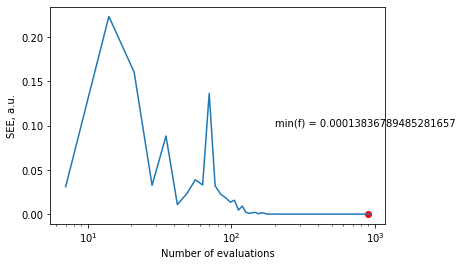

In [18]:
#plot error minimisation
fig, ax = plt.subplots()

ax.plot(evals,
        f_best)
for i in range(len(f_best)): #find where f was minimised and mark with red circle
    if f_best[i] == res1[1]:
        ax.scatter(evals[i],
                   f_best[i],
                   marker = 'o',
                   color = 'red')
        
        
ax.set_xlabel('Number of evaluations')
ax.set_ylabel('SEE, a.u.')
ax.set_xscale('log')
ax.text(200, .1, f'min(f) = {res1[1]}')

plt.savefig(r'./figures/optim_f-mins_20241128_wt.svg', dpi = 600, bbox_inches = 'tight')
plt.show()

In [19]:
res2 = cma.fmin(errorODE2, theta2, 2)

(3_w,7)-aCMA-ES (mu_w=2.3,w_1=58%) in dimension 3 (seed=949968, Thu Nov 28 09:15:58 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      7 9.132497969032404e-01 1.0e+00 1.87e+00  2e+00  2e+00 0:00.0
    2     14 2.745173851424658e-02 1.3e+00 2.07e+00  2e+00  2e+00 0:00.0
    3     21 4.086927869002031e-03 1.3e+00 2.48e+00  2e+00  3e+00 0:00.0
  100    700 4.042915026427174e-04 2.6e+01 1.12e-02  4e-04  5e-04 0:00.6
  149   1043 4.042910268606273e-04 5.4e+02 7.10e-04  1e-05  2e-05 0:00.8
termination on tolfun=1e-11 (Thu Nov 28 09:15:59 2024)
final/bestever f-value = 4.042910e-04 4.042910e-04 after 1044/1044 evaluations
incumbent solution: [-6.23222263961112, -3.3724248507333012, -2.6499939082630712]
std deviation: [1.1767348379410948e-05, 1.1910362914623339e-05, 1.674269385139117e-05]


In [20]:
res2[0]

array([-6.23222264, -3.37242485, -2.64999391])

In [21]:
#load logger
logger2 = res2[-1]
#load function evaluations
f_dat = logger2.load().data['f']
#loaf best f-value for each iteration
f_best = f_dat[:, 5]
evals = f_dat[:, 1]

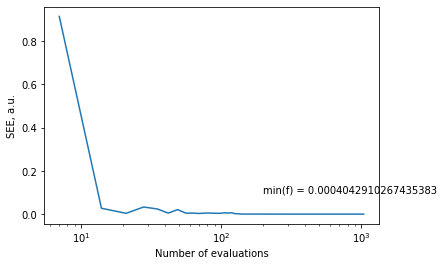

In [22]:
#plot error minimisation
fig, ax = plt.subplots()

ax.plot(evals,
        f_best)
for i in range(len(f_best)): #find where f was minimised and mark with red circle
    if f_best[i] == res2[1]:
        ax.scatter(evals[i],
                   f_best[i],
                   marker = 'o',
                   color = 'red')
        
        
ax.set_xlabel('Number of evaluations')
ax.set_ylabel('SEE, a.u.')
ax.set_xscale('log')
ax.text(200, .1, f'min(f) = {res2[1]}')

plt.savefig(r'./figures/optim_f-mins_20241128_sl.svg', dpi = 600, bbox_inches = 'tight')
plt.show()

In [9]:
#fit experimental data with curve_fit
WT_popt, WT_pcov = curve_fit(lambda t, a, b: a * np.log(t) + b,
                             params.time[1:], params.WT_data[1:]) #exclude origin

short_popt, short_pcov = curve_fit(lambda t, a, b: a * np.log(t) + b,
                             params.time[1:], params.short_data[1:]) #exclude origin

#create array with curve_fit data
x = np.linspace(0,60,600)

WT_pred = np.zeros(len(x))
short_pred = np.zeros(len(x))

for i in range(1, len(x)):
    WT_pred[i] = WT_popt[0] * np.log(x[i]) + WT_popt[1]
    short_pred[i] =  short_popt[0] * np.log(x[i]) + short_popt[1]

In [10]:
wt, ts = frac1([-5.24462493, -4.40465711, 9.2531963])
short, ts2 = frac2([-6.23222264, -3.37242485, -2.64999391])
short_scatter2 = np.interp(params.time, ts2, short)
wt_scatter2 = np.interp(params.time, ts, wt)

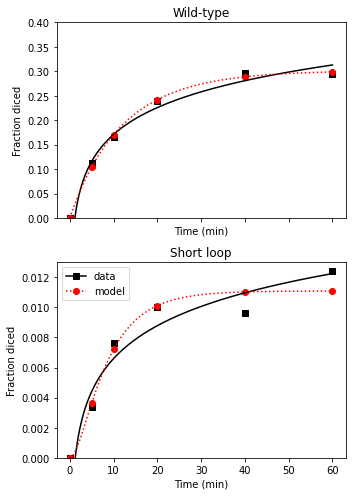

In [11]:
fig, ax = plt.subplots(2, sharex = True, figsize = (5, 7))

ax[0].set_ylim(0, 0.4)

ax[0].plot(x,
           WT_pred,
           color = 'black')
ax[0].plot(ts,
           wt,
           linestyle = ':',
           color = 'red')
ax[0].scatter(params.time,
              params.WT_data,
              marker = 's',
              color = 'black')
ax[0].scatter(params.time,
              wt_scatter2,
              marker = 'o',
              color = 'red')

ax[0].set_xlabel('Time (min)')
ax[0].set_ylabel('Fraction diced')
ax[0].set_title('Wild-type')

ax[1].plot(x,
           short_pred,
           color = 'black')
ax[1].plot(ts2,
           short,
           linestyle = ':',
           color = 'red')
ax[1].scatter(params.time,
              params.short_data,
              marker = 's',
              color = 'black')
ax[1].scatter(params.time,
              short_scatter2,
              marker = 'o',
              color = 'red')

ax[1].set_xlabel('Time (min)')
ax[1].set_ylabel('Fraction diced')
ax[1].set_title('Short loop')

ax[1].set_ylim(0, 0.0130)

l1 = mlines.Line2D([], [], marker = 's', color = 'black', label = 'data')
l2 = mlines.Line2D([], [], linestyle = ':', marker = 'o', color = 'red', label = 'model')

plt.legend(handles = [l1, l2], loc = 2)

plt.tight_layout()

plt.savefig('figures/20241128_new_optim.svg', dpi = 600, bbox_inches = 'tight')
plt.show()

In [15]:
colors = [i[0] for i in params.colors] + ['#88CCEE']
lines = ['-', ':', '--', '-.', '-']
to_plot = ['pMiR', 'miR', 'pMiR_dicer', 'pMiR_dicer_star', 'dicer_scaled']
ka1, ka2, kc1, kc2, kd1, kd2 = params.theta

In [18]:
output1 = solve_ivp(runModel1, (0, int(params.minutes)), init_values, \
                    method = 'LSODA', args = (ka1,kc1, kd1))
output2 = solve_ivp(runModel1, (0, int(params.minutes)), init_values, \
                    method = 'LSODA', args = (ka2,kc2, kd2))

In [39]:
#unpack species
order = ['pMiR', 'pMiR_dicer', 'pMiR_dicer_star', 'miR', 'dicer']
wt_res = {}
short_res = {}

j = 0
for i in range(len(output1.y)):
    wt_res[order[j]] = output1.y[i]
    if order[j] == 'dicer':
        wt_res['dicer_scaled'] = output1.y[i] / 5
        
    short_res[order[j]] = output2.y[i]
    if order[j] == 'dicer':
        short_res['dicer_scaled'] = output2.y[i] / 5
        
    j += 1

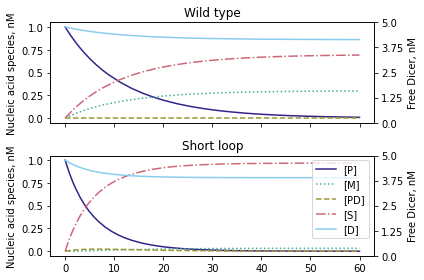

In [41]:
fig, ax = plt.subplots(2, sharex = True, sharey = True)

for i in range(len(to_plot)):
    ax[0].plot(output1.t,
               wt_res[to_plot[i]],
               color = colors[i],
               linestyle = lines[i])
ax[0].set_yticks(np.linspace(0,1,5), labels = np.linspace(0,1,5))
ax[0].set_ylabel('Nucleic acid species, nM')
ax0 = ax[0].twinx()
ax0.set_yticks(np.linspace(0,1,5), labels = np.linspace(0,5,5))
ax0.set_ylabel('Free Dicer, nM')

ax[0].set_title('Wild type')

for i in range(len(to_plot)):
    ax[1].plot(output2.t,
               short_res[to_plot[i]],
               color = colors[i],
               linestyle = lines[i])
ax[1].set_yticks(np.linspace(0,1,5), labels = np.linspace(0,1,5))
ax[1].set_ylabel('Nucleic acid species, nM')
ax1 = ax[1].twinx()
ax1.set_yticks(np.linspace(0,1,5), labels = np.linspace(0,5,5))
ax1.set_ylabel('Free Dicer, nM')

ax[1].set_title('Short loop')

leg = []
for i in range(len(colors)):
    leg.append(mlines.Line2D([], [], linestyle = lines[i], color = colors[i], 
                             label = ['[P]', '[M]', '[PD]', '[S]', '[D]'][i]))
               
plt.legend(handles = leg, loc = 1)

fig.tight_layout()

plt.savefig('./figures/overlay_species.svg', dpi = 600, bbox_inches = 'tight')
plt.show()

In [51]:
ka = [np.exp(res1[0][0])]
kb = [np.exp(res1[0][0]) * params.Kd_wt]
kc = [np.exp(res1[0][1])]
kd = [np.exp(res1[0][2])]

In [52]:
ks = [ka, kb, kc, kd] 
inits = [params.init_pMiR1, params.init_pMiR1_dcr, params.init_pMiR1_dcr_star, 
                 params.init_MiR1]

In [53]:
#variation of ks, dicer concentration (single miRNA)
kvars = [10**i for i in list(np.linspace(-2,2,9))]
dvars = np.linspace(0, 7.25, 15)
dvars[0] = 0.01
dvars = np.append(dvars, np.linspace(10, 15, 4))

In [54]:
#set up ODEs, make model
ode = mu.makeODEs(inits + [0], ka, kb, kc, kd)

In [55]:
model = mu.makeModel(ode)

### Run model and save output

In [56]:
exec(model)

In [57]:
names = []
for i in tqdm(range(len(dvars))):
    for k in range(4):
        for j in range(len(kvars)):
            init = inits + [dvars[i]]
            if k == 0:
                ks = ([ka[0] * kvars[j]], kb, kc, kd)
            elif k == 1:
                ks = (ka, [kb[0] * kvars[j]], kc, kd)
            elif k == 2:
                ks = (ka, kb, [kc[0] * kvars[j]], kd)
            elif k == 3:
                ks = (ka, kb, kc, [kd[0] * kvars[j]])
            
            res = solve_ivp(runModel, (0, 3000), init, \
                            args = ks, method = 'LSODA',
                           atol = 1e-3)
            
            index = ['pMiR', 'pMiR_dicer', 'pMiR_dicer_star', 'miR', 'dicer']
            
            df = pd.DataFrame(res.y, index = index)
            df = df.transpose()
            df.insert(loc = 0, column = 'time_min', value = res.t)
            
            name = 'k' + ['a', 'b', 'c', 'd'][k] + '_' + str(int(kvars[j]*100)) + 'dvar_' + str(int(dvars[i]*100))
            names.append(name)
            
            df.to_csv('outputs/optim/csvs2/' + name + '.csv', index = False)

  0%|          | 0/19 [00:00<?, ?it/s]C:\Users\Sofia\AppData\Roaming\Python\Python39\site-packages\scipy\integrate\_ivp\lsoda.py:161: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  solver._y, solver.t = integrator.run(
100%|██████████| 19/19 [00:01<00:00, 11.39it/s]


In [58]:
for name in names:
    exec(name + ' = pd.read_csv("outputs/optim/csvs2/' + name + '.csv", header = [0])')

In [59]:
ends = np.zeros((4, len(kvars), len(dvars)))

for i in range(4):
    for j in range(len(kvars)):
        for k in range(len(dvars)):
            exec('miR = k' + ['a', 'b', 'c', 'd'][i]+ '_' + str(int(kvars[j]*100)) + 'dvar_' + str(int(dvars[k]*100)))
            
            ends[i, j, k] = miR['miR'].iloc[-1]

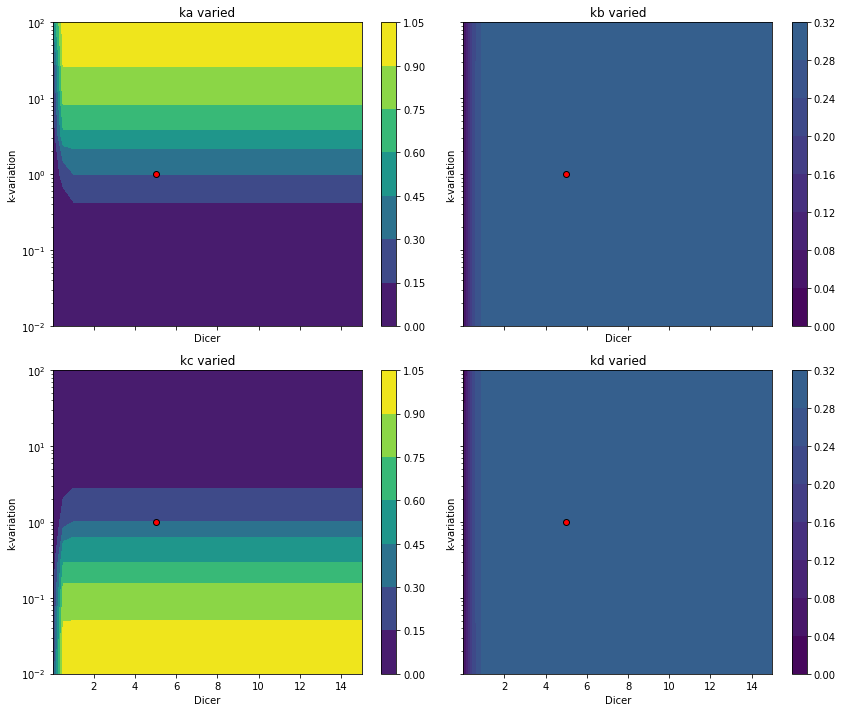

In [60]:
#plot
fig, ax = plt.subplots(2,2, sharex = True, sharey = True, figsize = (12, 10))

x = dvars
y = kvars

cs0 = ax[0,0].contourf(x, y, ends[0], vmin = 0, vmax = 1)
ax[0,0].set_title('ka varied')
fig.colorbar(cs0)
ax[0,0].set_xlabel('Dicer')
ax[0,0].set_ylabel('k-variation')
ax[0,0].scatter(5, 1, edgecolor = 'black', color = 'red')
ax[0,0].set_yscale('log')

cs1 = ax[0,1].contourf(x, y, ends[1], vmin = 0, vmax = 1)
ax[0,1].set_title('kb varied')
fig.colorbar(cs1)
ax[0,1].set_xlabel('Dicer')
ax[0,1].set_ylabel('k-variation')
ax[0,1].scatter(5, 1, edgecolor = 'black', color = 'red')
ax[0,1].set_yscale('log')

cs2 = ax[1,0].contourf(x, y, ends[2], vmin = 0, vmax = 1)
ax[1,0].set_title('kc varied')
fig.colorbar(cs2)
ax[1,0].set_xlabel('Dicer')
ax[1,0].set_ylabel('k-variation')
ax[1,0].scatter(5, 1, edgecolor = 'black', color = 'red')
ax[1,0].set_yscale('log')

cs3 = ax[1,1].contourf(x, y, ends[3], vmin = 0, vmax = 1)
ax[1,1].set_title('kd varied')
fig.colorbar(cs3)
ax[1,1].set_xlabel('Dicer')
ax[1,1].set_ylabel('k-variation')
ax[1,1].scatter(5, 1, edgecolor = 'black', color = 'red')
ax[1,1].set_yscale('log')

fig.tight_layout()

plt.savefig('outputs/optim/plots2/k-var_dvars2.svg', dpi = 600, bbox_inches = 'tight')
plt.show()

In [61]:
#what happens when increasing pmir concentration?
pvars = np.linspace(0, 1, 5)
pvars = np.append(pvars, np.linspace(1.5, 5, 8))
inits = [params.init_pMiR1_dcr, params.init_pMiR1_dcr_star, 
                 params.init_MiR1]

In [62]:
names2 = []
for i in tqdm(range(len(dvars))):
    for j in range(len(pvars)):
        init = [pvars[j]] + inits + [dvars[i]]
            
        res = solve_ivp(runModel, (0, 3000), init, args = (ka, kb, kc, kd), method = 'LSODA')
            
        index = ['pMiR', 'pMiR_dicer', 'pMiR_dicer_star', 'miR', 'dicer']
            
        df = pd.DataFrame(res.y, index = index)
        df = df.transpose()
        df.insert(loc = 0, column = 'time_min', value = res.t)
            
        name = 'pvar_' + str(int(pvars[j]*100)) + 'dvar_' + str(int(dvars[i]*100))
        names2.append(name)
            
        df.to_csv('outputs/optim/csvs2/' + name + '.csv', index = False)

100%|██████████| 19/19 [00:00<00:00, 25.82it/s]


In [63]:
for name in names2:
    exec(name + ' = pd.read_csv("outputs/optim/csvs2/' + name + '.csv", header = [0])')

In [64]:
ends2 = np.zeros((len(pvars), len(dvars)))

for j in range(len(pvars)):
    for k in range(len(dvars)):
        exec('miR = pvar_' + str(int(pvars[j]*100)) + 'dvar_' + str(int(dvars[k]*100)))
            
        ends2[j, k] = miR['miR'].iloc[-1]

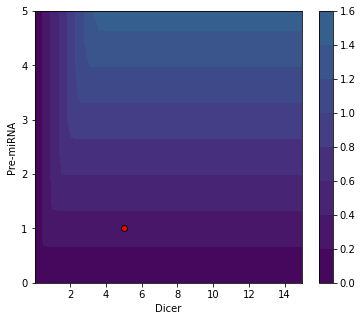

In [65]:
fig, ax = plt.subplots(figsize = (6,5))

x = dvars
y = pvars

cs = ax.contourf(x, y, ends2, vmin = 0, vmax = 5)
fig.colorbar(cs)
ax.set_xlabel('Dicer')
ax.set_ylabel('Pre-miRNA')
ax.scatter(5, 1, edgecolor = 'black', color = 'red')

plt.savefig('outputs/optim/plots2/premir-conc.svg', dpi = 600, bbox_inches = 'tight')

plt.show()

In [66]:
inits = [params.init_pMiR1_dcr, params.init_pMiR1_dcr_star, 
                 params.init_MiR1, params.init_dcr1]

In [67]:
names3 = []
for i in tqdm(range(len(pvars))):
    for j in range(len(kvars)):
        for k in range(4):
            init = [pvars[i]] + inits 
            if k == 0:
                ks = ([ka[0] * kvars[j]], kb, kc, kd)
            elif k == 1:
                ks = (ka, [kb[0] * kvars[j]], kc, kd)
            elif k == 2:
                ks = (ka, kb, [kc[0] * kvars[j]], kd)
            elif k == 3:
                ks = (ka, kb, kc, [kd[0] * kvars[j]])
            
            res = solve_ivp(runModel, (0, 3000), init, \
                            args = ks, method = 'LSODA',
                           atol = 1e-3)
            
            index = ['pMiR', 'pMiR_dicer', 'pMiR_dicer_star', 'miR', 'dicer']
            
            df = pd.DataFrame(res.y, index = index)
            df = df.transpose()
            df.insert(loc = 0, column = 'time_min', value = res.t)
            
            name = 'k' + ['a', 'b', 'c', 'd'][k] + '_' + str(int(kvars[j]*100)) + 'dvar_' + str(int(pvars[i]*100))
            names3.append(name)
            
            df.to_csv('outputs/optim/csvs2/' + name + '.csv', index = False)

100%|██████████| 13/13 [00:01<00:00, 10.62it/s]


In [68]:
for name in names3:
    exec(name + ' = pd.read_csv("outputs/optim/csvs2/' + name + '.csv", header = [0])')

In [69]:
ends3 = np.zeros((4, len(kvars), len(pvars)))

for i in range(4):
    for j in range(len(kvars)):
        for k in range(len(pvars)):
            exec('miR = k' + ['a', 'b', 'c', 'd'][i]+ '_' + str(int(kvars[j]*100)) + 'dvar_' + str(int(pvars[k]*100)))
            
            ends3[i, j, k] = miR['miR'].iloc[-1]

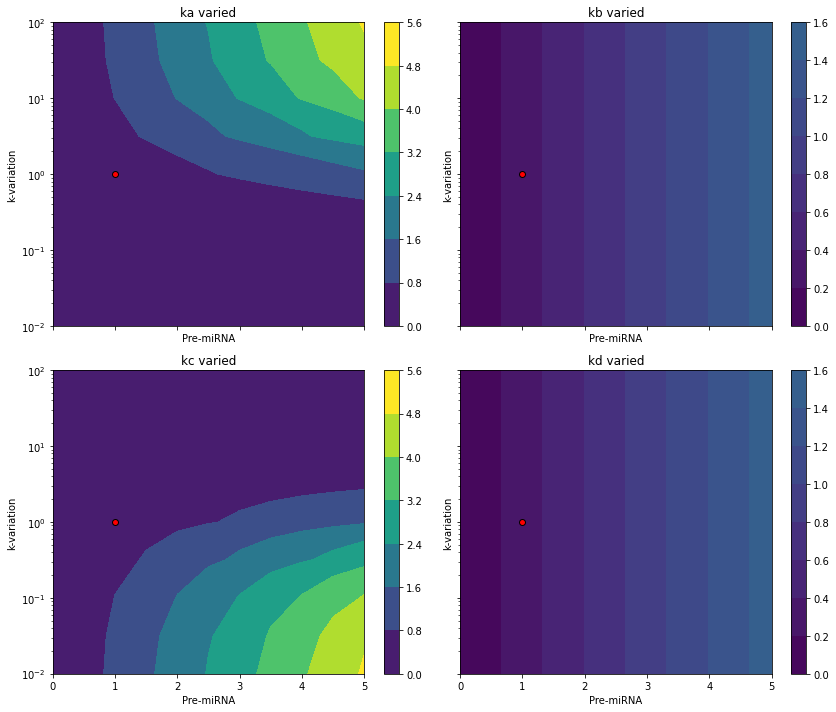

In [70]:
#plot
fig, ax = plt.subplots(2,2, sharex = True, sharey = True, figsize = (12, 10))

x = pvars
y = kvars

#plt.set_cmap('inferno')

cs0 = ax[0,0].contourf(x, y, ends3[0], vmin = 0, vmax = 5)
ax[0,0].set_title('ka varied')
fig.colorbar(cs0)
ax[0,0].set_xlabel('Pre-miRNA')
ax[0,0].set_ylabel('k-variation')
ax[0,0].scatter(1, 1, edgecolor = 'black', color = 'red')
ax[0,0].set_yscale('log')

cs1 = ax[0,1].contourf(x, y, ends3[1], vmin = 0, vmax = 5)
ax[0,1].set_title('kb varied')
fig.colorbar(cs1)
ax[0,1].set_xlabel('Pre-miRNA')
ax[0,1].set_ylabel('k-variation')
ax[0,1].scatter(1, 1, edgecolor = 'black', color = 'red')
ax[0,1].set_yscale('log')

cs2 = ax[1,0].contourf(x, y, ends3[2], vmin = 0, vmax = 5)
ax[1,0].set_title('kc varied')
fig.colorbar(cs2)
ax[1,0].set_xlabel('Pre-miRNA')
ax[1,0].set_ylabel('k-variation')
ax[1,0].scatter(1, 1, edgecolor = 'black', color = 'red')
ax[1,0].set_yscale('log')

cs3 = ax[1,1].contourf(x, y, ends3[3], vmin = 0, vmax = 5)
ax[1,1].set_title('kd varied')
fig.colorbar(cs3)
ax[1,1].set_xlabel('Pre-miRNA')
ax[1,1].set_ylabel('k-variation')
ax[1,1].scatter(1, 1, edgecolor = 'black', color = 'red')
ax[1,1].set_yscale('log')

fig.tight_layout()

plt.savefig('outputs/optim/plots2/k-var_pvars2.svg', dpi = 600, bbox_inches = 'tight')
plt.show()